In [41]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")

image_height/2 =3194.0


# Goal

The goal of this notebook is to check the vertical center calculation using various 0deg files and various profiles

This notebooks takes the profile files produced by the [profile](https://neutronimaging.ornl.gov/tutorials/imaging-notebooks/profile/linear-profile/) notebook.

<img src='static/screenshot_of_profile_file.png' />


In [49]:
import os
import pandas as pd
import numpy as np
import lmfit
import glob

from ipywidgets import interactive
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib notebook

Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


In [3]:
base_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

## working with various profiles and 3 different 0deg images

In [9]:
list_profile_files = glob.glob(os.path.join(base_folder, '0deg_profiles') + '/*.txt')
assert len(list_profile_files) > 0

In [28]:
def cleaning_list_name_columns(list_name_columns):
    clean_list_name_columns = []
    for _index_column, _line in enumerate(list_name_columns):
        _line_no_space = _line.replace(" ", "")
        file_name, col_name = _line_no_space.split("->")
        various_part_of_file_name = file_name.split("/")
        clean_list_name_columns.append(various_part_of_file_name[-1])
    return clean_list_name_columns

In [62]:
# {'profile_1': {'yaxis': [],
#                '0deg_file1': [],
#                '0deg_file2': [],
#                '0deg_file3': [],
#               },
#  'profile_2': ...
# #
profile_data_dict = {}

for _index, _file in enumerate(list_profile_files):
    base_file_name = os.path.basename(_file)
    
    pd_object = pd.read_csv(_file, skiprows=11)
    pd_header = pd.read_csv(_file, skiprows=5, nrows=3)
    list_names_of_columns = list(pd_header.columns)
    list_label_columns = list(pd_header.loc[:, list_names_of_columns[0]])
    clean_list_files = cleaning_list_name_columns(list_label_columns)

    _profile = pd_object.columns.values.tolist()
   
    profile_data_dict[base_file_name] = {'yaxis': None,
                                }
    list_name_of_pd_object_columns = list(pd_object.columns)
    y_axis = np.asarray(pd_object.loc[:, list_name_of_pd_object_columns[0]])
    profile_data_dict[base_file_name]['yaxis'] = y_axis
    for _col_index, _col_label in enumerate(list_name_of_pd_object_columns[1:]):
        profile_data_dict[base_file_name][clean_list_files[_col_index]] = np.asarray(pd_object.loc[:, _col_label])
    
    

In [63]:
profile_data_dict

{'IPTS-31716-first_experiment_ever_profile_1.txt': {'yaxis': array([1823, 1824, 1825, ..., 5190, 5191, 5192]),
  '0deg_30s_frames_OB_median.tif': array([7801.75, 7795.  , 7765.75, ..., 5415.  , 5311.5 , 5420.  ]),
  '0deg_nbr1_30s_frames_OB_median.tif': array([7962. , 8125.5, 8004. , ..., 5360. , 5282. , 5436.5]),
  '0deg_nbr2_30s_frames_OB.tif': array([7847. , 8152.5, 7736.5, ..., 4957. , 5133. , 4839.5])},
 'IPTS-31716-first_experiment_ever_profile_2.txt': {'yaxis': array([1835, 1836, 1837, ..., 4783, 4784, 4785]),
  '0deg_30s_frames_OB_median.tif': array([5388.75, 5618.  , 5465.  , ..., 4468.25, 4666.25, 4590.75]),
  '0deg_nbr1_30s_frames_OB_median.tif': array([5754.5, 5397.5, 5591. , ..., 4734.5, 4349.5, 4665. ]),
  '0deg_nbr2_30s_frames_OB.tif': array([5309.5, 5724.5, 4914. , ..., 4498.5, 4544.5, 4535.5])},
 'IPTS-31716-first_experiment_ever_profile_3.txt': {'yaxis': array([ 541,  542,  543, ..., 5914, 5915, 5916]),
  '0deg_30s_frames_OB_median.tif': array([5218.  , 5176.  , 5132.

In [71]:
# Goal is to create a master dict as followed

list_files = clean_list_files
#master_dict = {'profile1': {'file1': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            'file2': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            'file3': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            },
#               'profile2': {'file1': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            'file2': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            'file3': {'center_y_value': None, 'center_y_error': None, 'fitting': None},
#                            },
#                 ...
#                }

In [72]:
list_files

['0deg_30s_frames_OB_median.tif',
 '0deg_nbr1_30s_frames_OB_median.tif',
 '0deg_nbr2_30s_frames_OB.tif']

In [75]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

master_dict = {}
for _key in profile_data_dict.keys():
    # _key being the profile file name
    
    xaxis = profile_data_dict[_key]['yaxis']
    profile_dict = {}
    for _index_file, _file in enumerate(list_files):

        yaxis = profile_data_dict[_key][_file]

        pars = mod.make_params(c=yaxis.mean(),
                      center=3000,
                      sigma=xaxis.std(),
                      amplitude=xaxis.std() * yaxis.ptp())
        out = mod.fit(yaxis, pars, x=xaxis)
        
        profile_dict[_file] = {'center_y_value': round(out.params['center'].value),
                               'center_y_error': out.params['center'].stderr,
                               'fitting': out.best_fit,
                              }
    master_dict[_key] = profile_dict

In [76]:
master_dict

{'IPTS-31716-first_experiment_ever_profile_1.txt': {'0deg_30s_frames_OB_median.tif': {'center_y_value': 2956,
   'center_y_error': 1.4555409289681476,
   'fitting': array([7794.91253824, 7796.96478647, 7799.01601048, ..., 5301.54293252,
          5299.38647599, 5297.23069175])},
  '0deg_nbr1_30s_frames_OB_median.tif': {'center_y_value': 2958,
   'center_y_error': 2.373335096548484,
   'fitting': array([7843.25229251, 7845.34519817, 7847.43711269, ..., 5355.74085366,
          5353.62260383, 5351.50510629])},
  '0deg_nbr2_30s_frames_OB.tif': {'center_y_value': 2952,
   'center_y_error': 3.6144516024322293,
   'fitting': array([7826.20200452, 7828.22244049, 7830.24183411, ..., 5328.41489333,
          5326.24500256, 5324.07573751])}},
 'IPTS-31716-first_experiment_ever_profile_2.txt': {'0deg_30s_frames_OB_median.tif': {'center_y_value': 3100,
   'center_y_error': 1.588805891142034,
   'fitting': array([5362.96297118, 5364.57286709, 5366.18205042, ..., 4640.91439323,
          4639.106513

## Let's plot the center_y values found

<IPython.core.display.Javascript object>


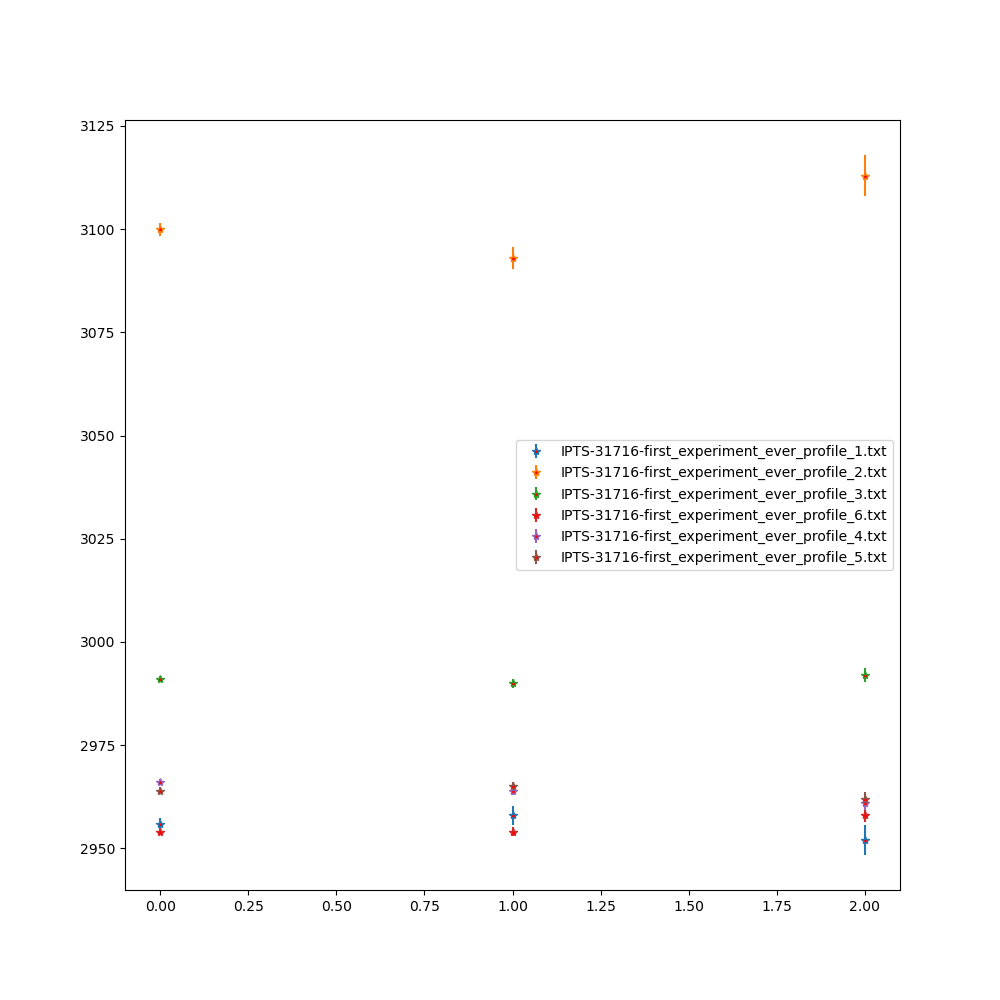

In [84]:
plt.figure(figsize=(10,10))

plt.title("y beam center for 6 different profiles using 3 different input files")

for profile_key in master_dict.keys():
    x_labels = []
    xaxis = np.arange(len(master_dict[profile_key].keys()))
    yaxis = []
    yerror = []
    for x_index, _key in enumerate(master_dict[profile_key].keys()):
        yaxis.append(master_dict[profile_key][_key]['center_y_value'])
        yerror.append(master_dict[profile_key][_key]['center_y_error'])
        x_labels.append(_key)

    plt.errorbar(xaxis, yaxis, yerr=yerror, linestyle='None', marker='*', markerfacecolor='r', label=profile_key)
    plt.legend()
    

<img src='static/position_of_the_vertical_profiles_0deg_images.png'/>

## conclusion 

Select the profile as close to the estimated center as possible